# CanESM5 GMD paper Figure 24
## Northern and Southern Annular modes, based on psl EOF 1.

CMOR variables: `psl`.

***This version has maps of the mean from CanESM5 and anomalies from observations***


### history
- NCS, setup basic example, 2019-05-08

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
%matplotlib inline
import xarray as xr
import numpy as np
import os, sys
from pprint import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import iris
import iris.coord_categorisation
import scipy 
from datetime import datetime
import cmocean
from cdo import Cdo
from eofs.xarray import Eof
import os
import cartopy
import matplotlib.path as mpath
import modules.plotting_module as pltm

os.environ["PATH"] += ':/home/ords/crd/ccrn/scrd104/miniconda3/bin/'
cdo = Cdo()
cdo.setCdo('/home/ords/crd/ccrn/scrd104/miniconda3/bin/cdo')

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
%store -r tr_start 
%store -r tr_end

start = tr_start
end = tr_end
startdate = datetime.strptime(start,'%Y-%m-%d')
enddate   = datetime.strptime(end,'%Y-%m-%d')

In [3]:
runCDO = False

if runCDO:   
    CanESM5_psl = 'psl_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
    ifile = os.path.join('input_data/CanESM5_cmip_dir/historical/r1i1p1f1/Amon/psl/gn/v20190306/', CanESM5_psl)
    ofile = 'input_data/processed_data/remap-woa09_' + CanESM5_psl
    cdo.remapbil('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', input=ifile, output=ofile)
    
    ERAInt_psl = 'psl_Amon_ERA-Int.nc'
    ifile = os.path.join('input_data/obs/ERA-Int/', ERAInt_psl)
    ofile = 'input_data/processed_data/remap-woa09_' + ERAInt_psl
    cdo.remapbil('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', input=ifile, output=ofile)


In [4]:
psl = xr.open_dataset('input_data/processed_data/remap-woa09_psl_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')['psl'] #units Pa
psl = psl.sel(time=slice(start, end))
psl_obs  = (xr.open_dataset('input_data/processed_data/remap-woa09_era5_psl_monthlymean_1979-2019.nc')['msl']).sel(time=slice(start, end)) #convert Pa to hPa


In [5]:
psl_sof20s = psl.sel(lat=slice(-90,-20))
psl_sof20s =psl_sof20s - psl_sof20s.mean(dim='time')
coslat = np.cos(np.deg2rad(psl_sof20s.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
#psl_sof20s
solver = Eof(psl_sof20s, weights=wgts)
sh_eof = solver.eofsAsCorrelation(neofs=1)
var_s = solver.varianceFraction(neigs=1)

psl_sof20s_obs = psl_obs.sel(lat=slice(-90,-20))
psl_sof20s_obs = psl_sof20s_obs - psl_sof20s_obs.mean(dim='time')
#psl_sof20s
solver_obs = Eof(psl_sof20s_obs, weights=wgts)
sh_eof_obs = solver_obs.eofsAsCorrelation(neofs=1)
var_s_obs = solver_obs.varianceFraction(neigs=1)

In [6]:
cube = iris.load_cube('input_data/processed_data/remap-woa09_psl_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')
cube2 = iris.load_cube('input_data/processed_data/remap-woa09_era5_psl_monthlymean_1979-2019.nc')

iris.coord_categorisation.add_season(cube, 'time', name='clim_season')
iris.coord_categorisation.add_season_year(cube, 'time', name='season_year')

iris.coord_categorisation.add_season(cube2, 'time', name='clim_season')
iris.coord_categorisation.add_season_year(cube2, 'time', name='season_year')


annual_seasonal_mean = cube.aggregated_by(['clim_season', 'season_year'],iris.analysis.MEAN)
annual_seasonal_mean2 = cube2.aggregated_by(['clim_season', 'season_year'],iris.analysis.MEAN)

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(message % (variable_name, nc_var_name))


In [7]:
psl = xr.DataArray.from_iris(annual_seasonal_mean.extract(iris.Constraint(clim_season='djf'))).sel(time=slice(start, end))
psl_obs = xr.DataArray.from_iris(annual_seasonal_mean2.extract(iris.Constraint(clim_season='djf'))).sel(time=slice(start, end))

In [8]:
psl_nof20n = psl.sel(lat=slice(20,90))
psl_nof20n = psl_nof20n - psl_nof20n.mean(dim='time')

coslat = np.cos(np.deg2rad(psl_nof20n.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]

#psl_sof20s
nsolver = Eof(psl_nof20n, weights=wgts)
nh_eof = nsolver.eofsAsCorrelation(neofs=1)
var_n = nsolver.varianceFraction(neigs=1)

psl_nof20n_obs = psl_obs.sel(lat=slice(20,90))
psl_nof20n_obs = psl_nof20n_obs - psl_nof20n_obs.mean(dim='time')

#psl_sof20s
nsolver_obs = Eof(psl_nof20n_obs, weights=wgts)
nh_eof_obs = nsolver_obs.eofsAsCorrelation(neofs=1)
var_n_obs = nsolver_obs.varianceFraction(neigs=1)

In [9]:
#add cyclic point to remove line at 0degrees

nh_eof = pltm.addCyclicPoint(nh_eof, 'lon')
sh_eof = pltm.addCyclicPoint(sh_eof, 'lon')
nh_eof_obs = pltm.addCyclicPoint(nh_eof_obs, 'lon')
sh_eof_obs = pltm.addCyclicPoint(sh_eof_obs, 'lon')

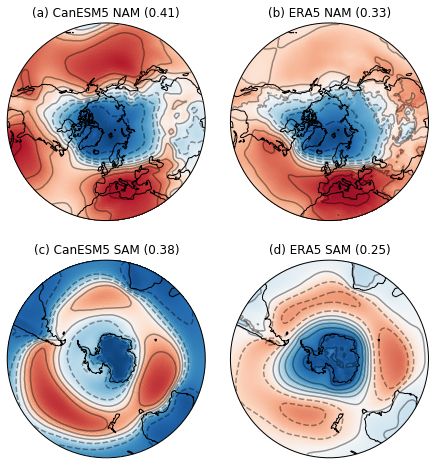

In [10]:
fig=plt.figure(figsize=(12,8))
   
# CanESM5
ax = plt.subplot2grid((2, 2), (0, 0),projection=ccrs.NorthPolarStereo())
ax.pcolormesh(nh_eof.lon, nh_eof.lat,nh_eof[0,...],vmin=-1,vmax=1,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(), rasterized=True)
ax.contour(nh_eof.lon, nh_eof.lat,nh_eof[0,...],10,transform=ccrs.PlateCarree(),colors='k', zorder=20, alpha=0.4)

ax.set_extent([-180, 180, 20, 90],ccrs.PlateCarree())
ax.coastlines()
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_title('(a) CanESM5 NAM ({0:.2f})'.format(var_n.values[0]))

# Had
ax = plt.subplot2grid((2, 2), (0, 1),projection=ccrs.NorthPolarStereo())
ax.pcolormesh(nh_eof_obs.lon, nh_eof_obs.lat,-nh_eof_obs[0,...],vmin=-1,vmax=1,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(), rasterized=True)
ax.contour(nh_eof_obs.lon, nh_eof_obs.lat,-nh_eof_obs[0,...],10,transform=ccrs.PlateCarree(),colors='k',zorder=20, alpha=0.4)
ax.set_extent([-180, 180, 20, 90],ccrs.PlateCarree())
ax.coastlines(linewidth=1)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_title('(b) ERA5 NAM ({0:.2f})'.format(var_n_obs.values[0]))

# CanESM5
ax = plt.subplot2grid((2, 2), (1, 0),projection=ccrs.SouthPolarStereo())
ax.pcolormesh(sh_eof.lon, sh_eof.lat,-sh_eof[0,...],vmin=-1,vmax=1,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(), rasterized=True)
ax.contour(sh_eof.lon, sh_eof.lat,-sh_eof[0,...],transform=ccrs.PlateCarree(),colors='k',zorder=20, alpha=0.4)

ax.set_extent([-180, 180, -90, -20],ccrs.PlateCarree())
ax.coastlines()
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_title('(c) CanESM5 SAM ({0:.2f})'.format(var_s.values[0]))

# Had
ax = plt.subplot2grid((2, 2), (1, 1),projection=ccrs.SouthPolarStereo())
ax.pcolormesh(sh_eof_obs.lon, sh_eof_obs.lat,sh_eof_obs[0,...],vmin=-1,vmax=1,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(), rasterized=True)
ax.contour(sh_eof_obs.lon, sh_eof_obs.lat,-sh_eof_obs[0,...],transform=ccrs.PlateCarree(),colors='k',zorder=20, alpha=0.4)

ax.set_extent([-180, 180, -90, -20],ccrs.PlateCarree())
ax.coastlines()
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_title('(d) ERA5 SAM ({0:.2f})'.format(var_s_obs.values[0]))
plt.subplots_adjust(wspace=-0.5)

fig.savefig('plots/fig-24_atmos_nam_sam.png', bbox_inches='tight')
fig.savefig('plots/fig-24_atmos_nam_sam.pdf', bbox_inches='tight')